In [ ]:
!pip install torch

In [44]:
#@title 1.3. IMPORT LIBRARY
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

In [45]:
#@title 1.4. RETRIEVE DATA
df_credit = pd.read_csv('/workspaces/functional-kan/phase_1/data/german_credit_data.csv')
df_credit['Risk'] = df_credit['Risk'].map({'good': 1, 'bad': 0})
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,NaN,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0


In [94]:
X = df_credit.drop(columns='Risk')
X = pd.get_dummies(X, dtype='int')
y = df_credit['Risk']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the result back to a DataFrame (optional)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df = pd.concat([X_scaled, y], axis=1)
# df_train, df_test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Risk'])
# df_train.head()

df.head()



,Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk
0,2.766456,0.146949,-0.745131,-1.236478,-0.670280,0.670280,-0.347960,0.634448,-0.466933,-1.232433,...,-0.259299,-0.327749,-0.712949,-0.110208,-0.250398,-0.470108,1.603567,-0.149983,-0.110208,1
1,-1.191404,0.146949,0.949817,2.248194,1.491914,-1.491914,-0.347960,0.634448,-0.466933,0.811403,...,-0.259299,-0.327749,-0.712949,-0.110208,-0.250398,-0.470108,1.603567,-0.149983,-0.110208,0
2,1.183312,-1.383771,-0.416562,-0.738668,-0.670280,0.670280,-0.347960,0.634448,-0.466933,0.811403,...,-0.259299,-0.327749,-0.712949,-0.110208,3.993639,-0.470108,-0.623610,-0.149983,-0.110208,1
3,0.831502,0.146949,1.634247,1.750384,-0.670280,0.670280,2.873893,-1.576173,-0.466933,0.811403,...,-0.259299,-0.327749,-0.712949,-0.110208,-0.250398,2.127172,-0.623610,-0.149983,-0.110208,1
4,1.535122,0.146949,0.566664,0.256953,-0.670280,0.670280,2.873893,-1.576173,-0.466933,0.811403,...,-0.259299,-0.327749,1.402626,-0.110208,-0.250398,-0.470108,-0.623610,-0.149983,-0.110208,0


In [36]:
from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
# model = KAN(width=[24, 1], grid=3, k=3, seed=42, device=device)

cpu


In [47]:
class CreditDataSet(Dataset):
    def __init__(self, df):
        super().__init__()
        # Convert data to a NumPy array and assign to self.data
        self.data = df.to_numpy()
        
    # Implement __len__ to return the number of data samples
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        features = self.data[idx, :-1]
        # Assign last data column to label
        label = self.data[idx, -1]
        return features, label

# Get a batch of features and labels
# features, labels = next(iter(dataloader_train))
# print(features, labels)

In [92]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the three linear layers
        self.fc1 = nn.Linear(24, 48)
        self.fc2 = nn.Linear(48, 48)
        self.fc3 = nn.Linear(48, 1)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        # Pass x through linear layers adding activations
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout(x)
        x = nn.functional.sigmoid(self.fc3(x))
        return x
            
def train_model(optimizer, net, criterion, num_epochs, dataloader_train):
    for epoch in tqdm(range(num_epochs)):
        for features, labels in dataloader_train:
            optimizer.zero_grad()
            outputs = net(features.double())
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()

def evaluate_accuracy(net, dataloader):
    acc = Accuracy('binary').to(torch.device('cpu'))
    net.eval()  # Set to evaluation mode
    with torch.no_grad():
        for features, labels in dataloader:
            outputs = net(features.double())
            preds = (outputs >= 0.5).float()
            acc(preds, labels.view(-1, 1))
    return acc.compute().item()
    


In [93]:
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
import torch.nn as nn

learning_rates = [0.1]
accuracy_train = []
accuracy_test = []

# Set up 10-fold stratified cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(skf.split(df, df['Risk'])):
    print(f"Fold {fold + 1}")

    # Split the data into training and testing sets based on the current fold
    df_train = df.iloc[train_index]
    df_test = df.iloc[test_index]

    # Create datasets from the train and test sets
    dataset_train = CreditDataSet(df_train)
    dataset_test = CreditDataSet(df_test)

    # Create DataLoaders for training and testing
    dataloader_train = DataLoader(
        dataset_train,
        batch_size=100,
        shuffle=True,
    )
    dataloader_test = DataLoader(
        dataset_test,
        batch_size=100,
        shuffle=False,
    )

    # Iterate over the learning rates (although only one in this example)
    for lr in learning_rates:
        net = Net()  # Re-initialize the network for each fold and learning rate
        optimizer = optim.SGD(net.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss

        # Train the model on the current training fold
        train_model(
            optimizer=optimizer,
            net=net,
            criterion=criterion,
            num_epochs=500,  # Adjust as needed
            dataloader_train=dataloader_train,
        )

        # Evaluate the model on both the training and test sets
        accuracy = evaluate_accuracy(net, dataloader_train)
        val = evaluate_accuracy(net, dataloader_test)

        print(f"Learning Rate: {lr}, Train Accuracy: {accuracy}, Test Accuracy: {val}")

        # Store the accuracy results
        accuracy_train.append(accuracy)
        accuracy_test.append(val)

# Optionally, summarize results across all folds
print(f"Average Train Accuracy: {sum(accuracy_train) / len(accuracy_train):.3f}")
print(f"Average Test Accuracy: {sum(accuracy_test) / len(accuracy_test):.3f}")


Fold 1


100%|██████████| 500/500 [00:04<00:00, 108.77it/s]


Learning Rate: 0.1, Train Accuracy: 0.8255555629730225, Test Accuracy: 0.75
Fold 2


100%|██████████| 500/500 [00:04<00:00, 112.35it/s]


Learning Rate: 0.1, Train Accuracy: 0.8266666531562805, Test Accuracy: 0.75
Fold 3


100%|██████████| 500/500 [00:04<00:00, 109.26it/s]


Learning Rate: 0.1, Train Accuracy: 0.8288888931274414, Test Accuracy: 0.7300000190734863
Fold 4


100%|██████████| 500/500 [00:04<00:00, 111.11it/s]


Learning Rate: 0.1, Train Accuracy: 0.8411111235618591, Test Accuracy: 0.7200000286102295
Fold 5


100%|██████████| 500/500 [00:04<00:00, 108.33it/s]


Learning Rate: 0.1, Train Accuracy: 0.8377777934074402, Test Accuracy: 0.7400000095367432
Fold 6


100%|██████████| 500/500 [00:04<00:00, 111.25it/s]


Learning Rate: 0.1, Train Accuracy: 0.8311111330986023, Test Accuracy: 0.6899999976158142
Fold 7


100%|██████████| 500/500 [00:04<00:00, 109.57it/s]


Learning Rate: 0.1, Train Accuracy: 0.8366666436195374, Test Accuracy: 0.6700000166893005
Fold 8


100%|██████████| 500/500 [00:04<00:00, 108.08it/s]


Learning Rate: 0.1, Train Accuracy: 0.8333333134651184, Test Accuracy: 0.7400000095367432
Fold 9


100%|██████████| 500/500 [00:04<00:00, 110.93it/s]


Learning Rate: 0.1, Train Accuracy: 0.8222222328186035, Test Accuracy: 0.75
Fold 10


100%|██████████| 500/500 [00:04<00:00, 108.55it/s]

Learning Rate: 0.1, Train Accuracy: 0.8411111235618591, Test Accuracy: 0.7099999785423279
Average Train Accuracy: 0.832
Average Test Accuracy: 0.725


100%|██████████| 200/200 [00:07<00:00, 26.13it/s]


Learning Rate: 0.01, Accuracy: 0.7871428728103638, Test: 0.699999988079071


100%|██████████| 200/200 [00:07<00:00, 26.07it/s]


Learning Rate: 0.05, Accuracy: 0.8671428561210632, Test: 0.7133333086967468


100%|██████████| 200/200 [00:07<00:00, 26.26it/s]


Learning Rate: 0.1, Accuracy: 0.8842856884002686, Test: 0.7433333396911621


100%|██████████| 200/200 [00:07<00:00, 26.34it/s]


Learning Rate: 0.15, Accuracy: 0.8714285492897034, Test: 0.70333331823349


100%|██████████| 200/200 [00:07<00:00, 26.64it/s]


Learning Rate: 0.2, Accuracy: 0.8828571438789368, Test: 0.7233333587646484


100%|██████████| 200/200 [00:07<00:00, 26.53it/s]


Learning Rate: 0.25, Accuracy: 0.8728571534156799, Test: 0.7133333086967468


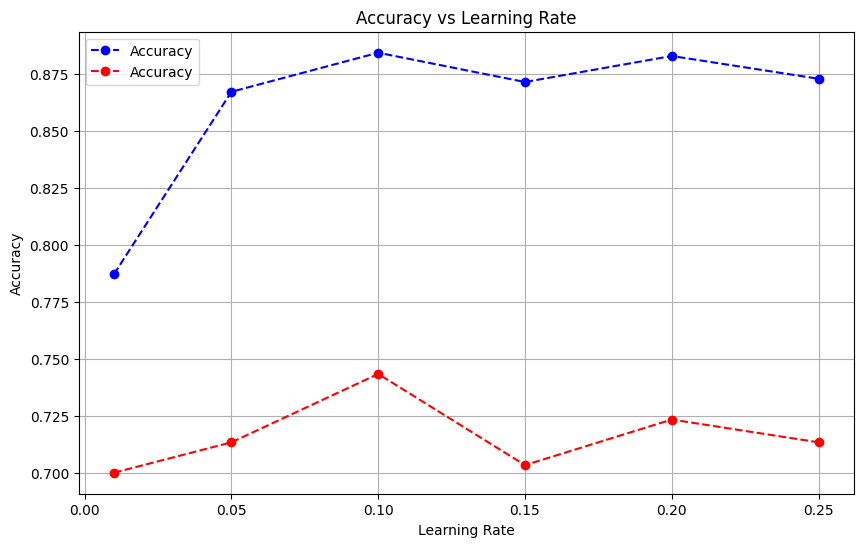

In [50]:
learning_rates = [0.1]
accuracy_train = []
accuracy_test = []

# Perform grid search over learning rates
for lr in learning_rates:
    net = Net()  # Re-initialize the network for each experiment
    optimizer = optim.SGD(net.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()  # Use standard binary cross-entropy

    train_model(
        optimizer=optimizer,
        net=net,
        criterion=criterion,
        num_epochs=200,  # Use fewer epochs for quick testing
        dataloader_train=dataloader_train
    )
    
    # Evaluate accuracy on training data (or use a test/validation set if available)
    accuracy = evaluate_accuracy(net, dataloader_train)
    val = evaluate_accuracy(net, dataloader_test)

    print(f"Learning Rate: {lr}, Accuracy: {accuracy}, Test: {val}")

    accuracy_train.append(accuracy)
    accuracy_test.append(val)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, accuracy_train, marker='o', linestyle='--', color='b', label='Accuracy')
plt.plot(learning_rates, accuracy_test, marker='o', linestyle='--', color='r', label='Accuracy')

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.legend()
plt.grid(True)
plt.show()